<a href="https://colab.research.google.com/github/djordjeviiccmilos/Data_Analisys/blob/main/MilosDjordjevic137RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistička obrada podataka o saobraćajnim nezgodama u Njujorku**
---

# **Uvod**
---

Cilj ovog projekta je da se primenom statističkih metoda analizira skup podataka o saobraćajnim nezgodama u Njujorku.

Skup podataka koji se koristi u ovom projektu sadrži fiktivne informacije o saobraćajnim nezgodama na teritoriji Njujorka, uključujući:


*   Datum i vreme incidenta,
*   Lokaciju (naselje, ulice, koordinate)
*   Broj povredjenih i stradalih (ukupno i po kategorijama: pešaci, biciklisti, vozači)
*   Doprinoseći faktor nezgode
*   Tip vozila koji je učestvovao u nezgodi

U ovom radu će se analizirati pitanja poput:


*   Da li je broj povredjenih i stradalih zavisi od godišnjeg doba?
*   Da li je prosečna težina nezgode veća vikendom nego radnim danima?
*   Koji su najčešći uzroci nezgoda i da li su statistički povezani sa većim brojem povredjenih?
*   Da li postoji statistički značajna razlika u broju i težini nezgode izmedju različitih delova grada (naselja)?
*   Kakva je raspodela težine nezgode i može li se modelirati poznatom raspodelom?





# **Priprema i čišćenje podataka**
---
Podaci o saobraćajnim nezgodama su učitani iz CSV datoteke u Pandas DataFrame objekat.

In [1]:
import pandas as pd

dataset = pd.read_csv("/content/drive/MyDrive/Statistika/NYC_Collisions.csv")

dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238421 entries, 0 to 238420
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Collision ID         238421 non-null  int64  
 1   Date                 238421 non-null  object 
 2   Time                 238421 non-null  object 
 3   Borough              231224 non-null  object 
 4   Street Name          238058 non-null  object 
 5   Cross Street         111291 non-null  object 
 6   Latitude             216098 non-null  float64
 7   Longitude            216098 non-null  float64
 8   Contributing Factor  237134 non-null  object 
 9   Vehicle Type         238421 non-null  object 
 10  Persons Injured      238420 non-null  float64
 11  Persons Killed       238421 non-null  int64  
 12  Pedestrians Injured  238421 non-null  int64  
 13  Pedestrians Killed   238421 non-null  int64  
 14  Cyclists Injured     238421 non-null  int64  
 15  Cyclists Killed  

,Collision ID,Date,Time,Borough,Street Name,Cross Street,Latitude,Longitude,Contributing Factor,Vehicle Type,Persons Injured,Persons Killed,Pedestrians Injured,Pedestrians Killed,Cyclists Injured,Cyclists Killed,Motorists Injured,Motorists Killed
0,4491746,2021-01-01,20:00:00,Bronx,Bruckner Expressway,NaN,40.83398,-73.826350,Pavement Slippery,Passenger Vehicle,0.0,0,0,0,0,0,0,0
1,4441905,2021-01-01,05:28:00,Brooklyn,Lafayette Avenue,NaN,40.68730,-73.973656,Unspecified,Passenger Vehicle,0.0,0,0,0,0,0,0,0
2,4382769,2021-01-01,06:00:00,Staten Island,West Shore Expressway,NaN,NaN,NaN,Fell Asleep,Passenger Vehicle,0.0,0,0,0,0,0,0,0
3,4380949,2021-01-01,19:30:00,Bronx,Sedgwick Avenue,Vancortlandt Avenue West,40.88270,-73.892730,NaN,Not Reported,0.0,0,0,0,0,0,0,0
4,4380940,2021-01-01,07:40:00,Brooklyn,Cortelyou Road,Mc Donald Avenue,40.63791,-73.978640,Unspecified,Passenger Vehicle,0.0,0,0,0,0,0,0,0


**Obrada nepoznatih vrednosti (NaN)**
---
Nakon inicijalnog pregleda podataka, primećujemo da neke kolone sadrže nepoznate vrednosti (Borough, Contributing Factor, Vehicle Type, Street Name...). To možemo, izmedju ostalog, zaključiti u razlici broja kolona izmedju ID-a nezgode i prethodno navedenih kolona.

In [2]:
dataset.isna().sum()

,0
Collision ID,0
Date,0
Time,0
Borough,7197
Street Name,363
Cross Street,127130
Latitude,22323
Longitude,22323
Contributing Factor,1287
Vehicle Type,0


In [3]:
dataset["Borough"] = dataset["Borough"].fillna("Unspecified")
dataset["Contributing Factor"] = dataset["Contributing Factor"].fillna("Unspecified")
dataset["Vehicle Type"] = dataset["Vehicle Type"].fillna("Unspecified")
dataset["Street Name"] = dataset["Street Name"].fillna("Unspecified")

Kolone kao što su Cross Street, Longitude, Latitude ćemo obrisati jer neće biti analizirane. Takodje, kolona Persons Injured ima jednu NaN vrednost koju ćemo ukloniti, jer statistički nije relevantna.

In [4]:
dataset = dataset[dataset["Persons Injured"].notna()]

dataset = dataset.drop(columns=["Latitude", "Longitude", "Cross Street"])

In [5]:
dataset.isna().sum()

,0
Collision ID,0
Date,0
Time,0
Borough,0
Street Name,0
Contributing Factor,0
Vehicle Type,0
Persons Injured,0
Persons Killed,0
Pedestrians Injured,0


**Konverzija datuma i vremena**
---
Za analizu podatak koji su povezani sa vremenskim intervalima, datum i vreme moraju da budu konvertovani u odgovarajuće formate.


In [6]:
dataset["Datetime"] = pd.to_datetime(dataset["Date"] + " " + dataset["Time"])

dataset["Hour"] = dataset["Datetime"].dt.hour
dataset["Weekday"] = dataset["Datetime"].dt.weekday
dataset["Month"] = dataset["Datetime"].dt.month

**Kreiranje novih kolona**
---

U daljoj analizi su nam potrebne dodatne kolone kao što je kolona koja će nam odrediti težinu saobraćajne nezgode.

In [7]:
dataset["Accident Severity"] = (dataset["Persons Injured"] + dataset["Persons Killed"] * 10)

# **Osnovne statističke analize**
---
U ovom poglavlju su analizirane osnovne statističke karakteristike podataka vezanih za povredjene u saobraćajnim nezgodama, kao i kolona *Accident Severity* koja ukazuje na težinu same nezgode.

**Analiza raspodele i gustine verovatnoće**
---

Raspodela broja povredjenih osoba i težine nezgode prikazani su histogramima, na kojima se vidi učestanost pojedinih vrednosti u uzorku.


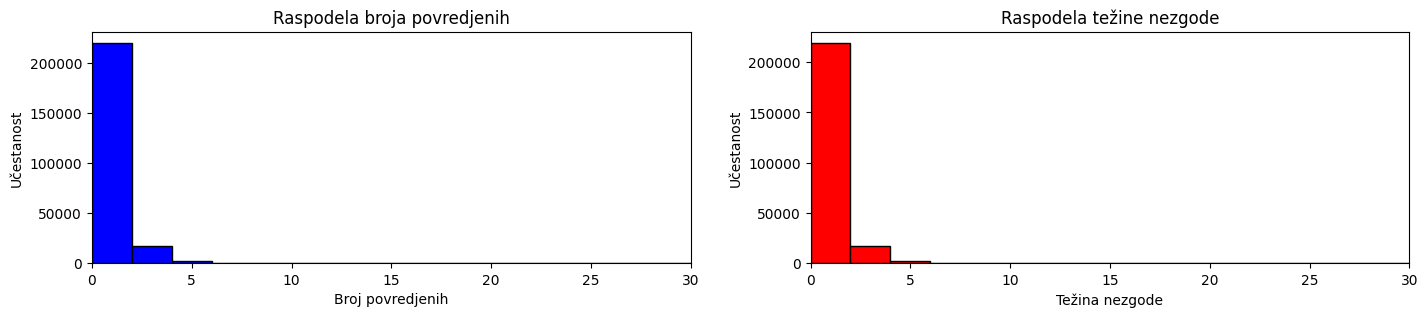

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 3))

plt.subplot(1, 2, 1)
plt.hist(dataset["Persons Injured"], bins = 20, color = "blue", edgecolor = "black")
plt.title("Raspodela broja povredjenih")
plt.xlabel("Broj povredjenih")
plt.xlim(0, 30)
plt.ylabel("Učestanost")


plt.subplot(1, 2, 2)
plt.hist(dataset["Accident Severity"], bins = 20, color = "red", edgecolor = "black")
plt.title("Raspodela težine nezgode")
plt.xlabel("Težina nezgode")
plt.xlim(0, 30)
plt.ylabel("Učestanost")

plt.show()

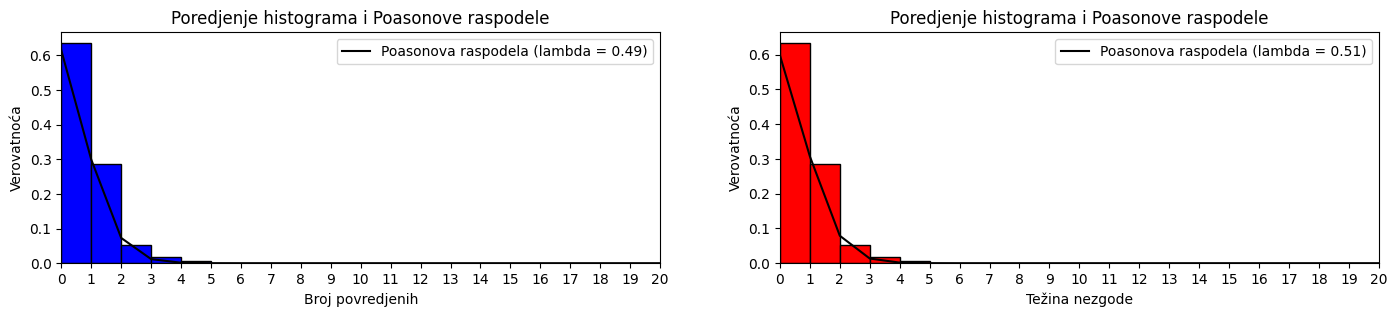

In [9]:
import numpy as np
from scipy.stats import poisson

persons_injured = dataset["Persons Injured"]
accident_severity = dataset["Accident Severity"]

lambda_persons_injured = persons_injured.mean()

lambda_accident_severity = accident_severity.mean()

x_persons_injured = np.arange(0, persons_injured.max() + 1)
x_accident_severity = np.arange(0, accident_severity.max() + 1)

poisson_persons_injured = poisson.pmf(x_persons_injured, mu = lambda_persons_injured)
poisson_accident_severity = poisson.pmf(x_accident_severity, mu = lambda_accident_severity)


plt.figure(figsize=(17, 3))

plt.subplot(1, 2, 1)
plt.hist(persons_injured, bins= range(0, int(persons_injured.max()) + 2), density = True, color = "blue", edgecolor = "black")
plt.plot(x_persons_injured, poisson_persons_injured, label=f"Poasonova raspodela (lambda = {lambda_persons_injured:.2f})", color = "black")
plt.xlabel("Broj povredjenih")
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 1))
plt.ylabel("Verovatnoća")
plt.title("Poredjenje histograma i Poasonove raspodele")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(accident_severity, bins= 40, density = True, color = "red", edgecolor = "black")
plt.plot(x_accident_severity, poisson_accident_severity, label=f"Poasonova raspodela (lambda = {lambda_accident_severity:.2f})", color = "black")
plt.xlabel("Težina nezgode")
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 1))
plt.ylabel("Verovatnoća")
plt.title("Poredjenje histograma i Poasonove raspodele")
plt.legend()

plt.show()


**Osnovne statističke mere**
---

In [10]:
def stats(data):
  stats = {
      "Srednja vrednost: " : data.mean(),
      "Medijana: " : data.median(),
      "Donji kvartil (Q1): " : data.quantile(0.25),
      "Gornji kvartil (Q3): " : data.quantile(0.75),
      "Minimum: " : data.min(),
      "Maksimum: " : data.max(),
      "Raspon: " : data.max() - data.min(),
      "Disperzija: " : data.var(),
      "Standardna devijacija: " : data.std()
  }

  return pd.Series(stats)


stats_injured = stats(dataset["Persons Injured"])
stats_severity = stats(dataset["Accident Severity"])

stats_data = pd.concat([stats_injured, stats_severity], axis = 1)
stats_data.columns = ["Broj povredjenih", "Težina nezgode"]

stats_data = stats_data.round(2)

print(stats_data)

                         Broj povredjenih  Težina nezgode
Srednja vrednost:                    0.49            0.51
Medijana:                            0.00            0.00
Donji kvartil (Q1):                  0.00            0.00
Gornji kvartil (Q3):                 1.00            1.00
Minimum:                             0.00            0.00
Maksimum:                           40.00           40.00
Raspon:                             40.00           40.00
Disperzija:                          0.65            0.94
Standardna devijacija:               0.81            0.97


Iz ovih podataka dolazimo do sledećih zaključaka:

1.   Većina nezgoda nema teške ishode. Medijana kao i donji kvartil Q1 su nula za obe promenljive, što znači da je više od 50% slučajeva broj povredjenih i ukupna težina nezgode jednaka nuli.
2.   Maksimum je 40 za obe promenljive, što znači da postoje ekstremni slučajevi koji snažno odudaraju od većine. Raspon je velik u oba slučaja, što ukazuje na retkih ali veoma teških nezgoda.


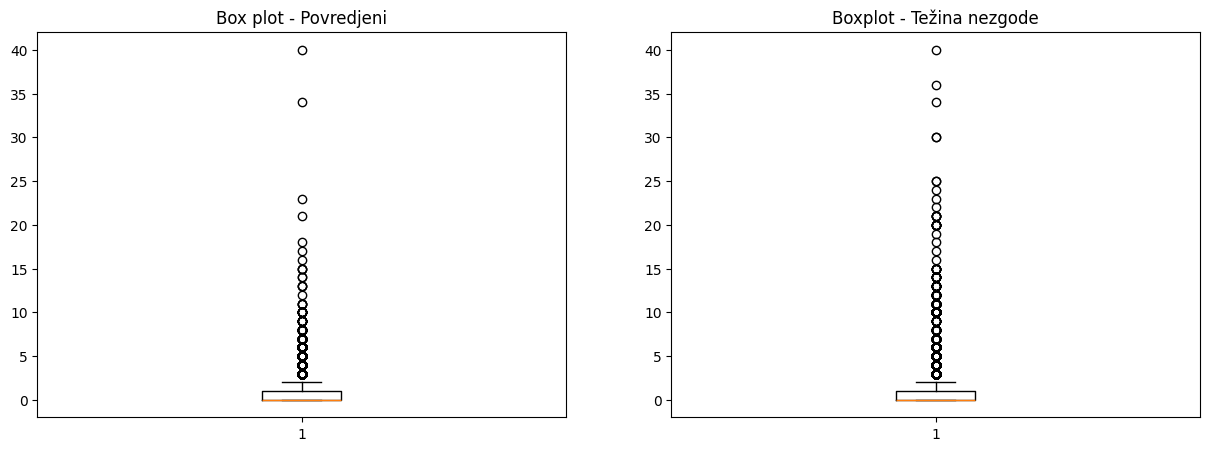

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(dataset["Persons Injured"])
plt.title("Box plot - Povredjeni")

plt.subplot(1, 2, 2)
plt.boxplot(dataset["Accident Severity"])
plt.title("Boxplot - Težina nezgode")

plt.show()

In [12]:
p_injured = (dataset["Persons Injured"] >= 1).mean()
p_killed = (dataset["Persons Killed"] >= 1).mean()

print(f"Verovatnoća da je >= 1 povredjen po nezgodi: {p_injured:.4f}")
print(f"Verovatnoća da je >= 1 stradao po nezgodi: {p_killed:.4f}")

Verovatnoća da je >= 1 povredjen po nezgodi: 0.3653
Verovatnoća da je >= 1 stradao po nezgodi: 0.0026


Verovatnoća da je bar jedna osoba povredjena u nezgodi je približno 37%. To znači da je u oko trećini svih nezgoda ima najmanje jedna povredjena osoba.

Verovanoća da u nezgodi strada bar jedna osoba je oko 3%, što ukazuje da su smrtni slučajevi značajno redji.

**Procena verovatnoća**
---

Jedan od osnovnih zadataka u analizi saobraćajnih nezgoda jeste procena kolika je verovatnoća da dodje do povredjivanja ili smrtnog ishoda u pojedinačnoj nezgodi.


Verovatnoća da nezgoda dovede do ≥ 1 povredjene osobe ili do ≥ 1 smrtnog ishoda računaćemo po definiciji.

P(X ≥ 1) = 1 - Nx=0 / N

Gde je Nx=0 broj nezgoda u kojima nije došlo do povrede ili smrtnih ishoda, a N ukupan broj nezgoda

In [23]:
persons_injured = dataset["Persons Injured"]

injured = {
    "Ukupan broj nezgoda: " : len(persons_injured),
    "Ukupan broj povreda: " : persons_injured.sum(),
    "Procenat broja povredjenih po nezgodi: " : persons_injured.mean(),
    "Procenat nezgoda sa >= 1 povredjenih: " : (persons_injured > 0).mean() * 100
}

for i, j in injured.items():
  print(f"{i}: {j:.2f}" if isinstance(j, float) else f"{i}: {j}")

Ukupan broj nezgoda: : 238420
Ukupan broj povreda: : 116226.00
Procenat broja povredjenih po nezgodi: : 0.49
Procenat nezgoda sa >= 1 povredjenih: : 36.53


In [41]:
persons_killed = dataset["Persons Killed"]

killed = {
    "Ukupan broj nezgoda: " : len(persons_killed),
    "Ukupan broj smrtnih ishoda: " : persons_killed.sum(),
    "Procenat broja smrtnih ishoda po nezgodi: " : persons_killed.mean(),
    "Procenat nezgoda sa ≥ 1 smrtnih ishoda: " : (persons_killed > 0).mean() * 100
}

for i, j in killed.items():
  print(f"{i}: {j:.4f}" if isinstance(j, float) else f"{i}: {j}")

Ukupan broj nezgoda: : 238420
Ukupan broj smrtnih ishoda: : 635
Procenat broja smrtnih ishoda po nezgodi: : 0.0027
Procenat nezgoda sa ≥ 1 smrtnih ishoda: : 0.2571


S obzirom na to da se povrede dešavaju relativno često, oko 37% podataka, modelirane su koristeći binomnu raspodelu. Binomna raspodela broji uspehe u n ponavljanja nezavisnih eksperimenata, pri čemu svaki eksperiment ima dva ishoda (uspeh ili neuspeh). Postavićemo fiktivan fiksan broj osoba u automobilu (npr. 3). Svako lice ima jednaku i nezavisnu verovatnoću p da bude povredjeno.



P(X = 0) = 0.5874
P(X = 1) = 0.3419
P(X = 2) = 0.0663
P(X > 2) = 0.0043




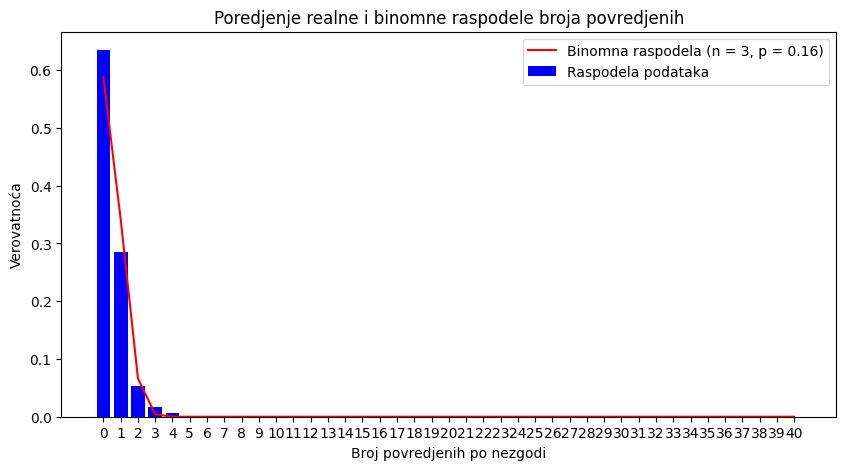

In [40]:
from scipy.stats import binom

persons_injured = dataset["Persons Injured"]
p_data_injured = persons_injured.value_counts(normalize = True).sort_index()

n = 3
p = persons_injured.mean() / n
x = np.arange(0, persons_injured.max() + 1)
binom_p = binom.pmf(x, n, p)

p_0 = binom.pmf(0, n, p)
p_1 = binom.pmf(1, n, p)
p_2 = binom.pmf(2, n, p)
p_n = binom.sf(2, n, p)

print(f"\n\nP(X = 0) = {p_0:.4f}")
print(f"P(X = 1) = {p_1:.4f}")
print(f"P(X = 2) = {p_2:.4f}")
print(f"P(X > 2) = {p_n:.4f}\n\n")

plt.figure(figsize=(10, 5))
plt.bar(p_data_injured.index, p_data_injured.values, label = "Raspodela podataka", color = "blue")
plt.plot(x, binom_p, color = "red", label = f"Binomna raspodela (n = {n}, p = {p:.2f})")
plt.xlabel("Broj povredjenih po nezgodi")
plt.xticks(np.arange(0, persons_injured.max() + 1))
plt.ylabel("Verovatnoća")
plt.title("Poredjenje realne i binomne raspodele broja povredjenih")
plt.legend()
plt.show()

Sa druge strane, smrtni ishodi su daleko redji nego povrede. Za njih je korišćena Poasonova raspodela. Za parametar λ koristićemo srednju vrednost (očekivanje).



P(X = 0) = 0.9973
P(X = 1) = 0.0027
P(X > 1) = 0.00000354




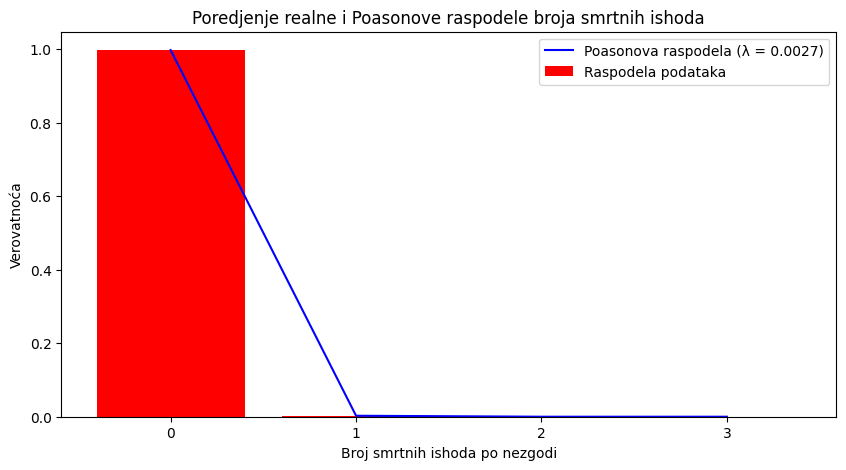

In [34]:
from scipy.stats import poisson

persons_killed = dataset["Persons Killed"]
p_data_killed = persons_killed.value_counts(normalize= True).sort_index()

lambda_killed = persons_killed.mean()
x = np.arange(0, persons_killed.max() + 1)
poisson_p = poisson.pmf(x, mu = lambda_killed)

p_0 = poisson.pmf(0, mu = lambda_killed)
p_1 = poisson.pmf(1, mu = lambda_killed)

print(f"\n\nP(X = 0) = {p_0:.4f}")
print(f"P(X = 1) = {p_1:.4f}")
print(f"P(X > 1) = {1 - p_0 - p_1:.8f}\n\n")

plt.figure(figsize=(10, 5))
plt.bar(p_data_killed.index, p_data_killed.values, label = "Raspodela podataka", color = "red")
plt.plot(x, poisson_p, label = f"Poasonova raspodela (λ = {lambda_killed:.4f})", color = "blue")
plt.xlabel("Broj smrtnih ishoda po nezgodi")
plt.xticks(np.arange(0, persons_killed.max() + 1))
plt.ylabel("Verovatnoća")
plt.title("Poredjenje realne i Poasonove raspodele broja smrtnih ishoda")
plt.legend()

plt.show()
